# BindsNET Learning Techniques

## 1. Table of Contents
1. Table of Contents
2. Overview
3. Import Statements
4. Learning Flow
    1. Define Simulation Parameters
    2. Create Input Data
    3. Configure Network Architecture
    4. Define Simulation Variables
    5. Perform Learning Iterations
    6. Evaluate Classification Performance
5. Learning Rules
    1. PostPre
    2. Hebbian
    3. WeightDependentPostPre
    4. MSTDP
    5. MSTDPET
6. Custom Learning Rules


## 2. Overview

Detail documentation of usage of learning rules has been specified [here](https://bindsnet-docs.readthedocs.io/guide/guide_part_ii.html). This document will go into more specific examples of configuring a spiking neural network in BindsNET.

The specified learning rule is passed into a `Connection` object via the `update_rule` argument. The connection encapsulates the learning rule object.

* `nu`: a 2-tuple pre- and post- synaptic learning rates (how quickly synapse weights change)
* `reduction`: specifies how parameter updates are aggregated across the batch dimension
* `weight_decay`: specifies the time constant of the rate of decay of synapse weights to zero

Parameter updates are averaged across the batch dimension by default, so there is no weight decay.


In [382]:
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.learning import PostPre

# Create two populations of neurons, one to act as the "source"
# population, and the other, the "target population".
# Neurons involved in certain learning rules must record synaptic
# traces, a vector of short-term memories of the last emitted spikes.
source_layer = Input(n=100, traces=True)
target_layer = LIFNodes(n=1000, traces=True)

# Connect the two layers.
connection = Connection(
    source=source_layer, target=target_layer, update_rule=PostPre, nu=(1e-4, 1e-2)
)

## 3. Import Statements

In [383]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

from bindsnet.encoding import *
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
from bindsnet.network.monitors import NetworkMonitor

from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_input, plot_weights

from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.learning import PostPre, Hebbian, WeightDependentPostPre, MSTDP, MSTDPET

from bindsnet.evaluation import all_activity, proportion_weighting, assign_labels
from bindsnet.utils import get_square_weights, get_square_assignments

## 4. Learning Flow

1. Define Simulation Parameters
2. Create Input Data
3. Configure Network Architecture
4. Define Simulation Variables
5. Perform Learning Iterations
6. Evaluate Classification Performance

### 4.1 Simulation Parameters

In [384]:
### Input Data Parameters ###

# number of training samples
training_samples = 10
testing_samples = 10

# set number of classes
n_classes = 2

### Network Configuration Parameters ###

# configure number of input neurons
input_layer_name = "Input Layer"
input_neurons = 9

# configure the number of output lif neurons
lif_layer_name = "LIF Layer"
lif_neurons = 2

### Simulation Parameters ###

# simulation time
time = 10
dt = 1

# number of training iterations
epochs = 100

# ratio of neurons to classes
per_class = int(lif_neurons / n_classes)

### 4.2 Input Configuration

In [385]:
# store unique images in a list
imgs = []

# Class 0 Image
img0 = {"Label" : 0, "Image" : torch.FloatTensor([[1,1,1],[1,0,1],[1,1,1]])}
imgs.append(img0)

# Class 1 Image
img1 = {"Label" : 1, "Image" : torch.FloatTensor([[0,1,0],[0,1,0],[0,1,0]])}
imgs.append(img1)

# initialize list of inputs for training
training_dataset = []

# for the number of specified training samples
for i in range(training_samples):

    # randomly select a training sample
    # rand_sample = random.randint(0,n_classes-1)
    
    # provide an even number of training samples
    rand_sample = i % n_classes

    # add the sample to the list of training samples
    training_dataset.append(imgs[rand_sample])

# initialize the encoder
encoder = BernoulliEncoder(time=time, dt=dt)

# list of encoded images for random selection during training
encoded_train_inputs = []

# loop through encode each image type and store into a list of encoded images
for sample in training_dataset:

    # encode the image 
    encoded_img = encoder(torch.flatten(sample["Image"]))

    # encoded image input for the network
    encoded_img_input = {input_layer_name: encoded_img}

    # encoded image label
    encoded_img_label = sample["Label"]

    # add to the encoded input list along with the input layer name
    encoded_train_inputs.append({"Label" : encoded_img_label, "Inputs" : encoded_img_input})

# initialize list of inputs for testing
testing_dataset = []

# for the number of specified testing samples
for i in range(testing_samples):

    # randomly select a training sample
    rand_sample = random.randint(0,n_classes-1)

    # add the sample to the list of training samples
    testing_dataset.append(imgs[rand_sample])

# list of encoded images for random selection during training
encoded_test_inputs = []

# loop through encode each image type and store into a list of encoded images
for sample in testing_dataset:

    # encode the image 
    encoded_img = encoder(torch.flatten(sample["Image"]))

    # encoded image input for the network
    encoded_img_input = {input_layer_name: encoded_img}

    # encoded image label
    encoded_img_label = sample["Label"]

    # add to the encoded input list along with the input layer name
    encoded_test_inputs.append({"Label" : encoded_img_label, "Inputs" : encoded_img_input})

### 4.3 Network Configuration

When creating a connection between two layers, the learning (update) rule should be specified as well as the learning rate (nu) 

In [386]:
# initialize network
network = Network()

# configure weights for the synapses between the input layer and LIF layer
w = torch.round(torch.abs(2 * torch.randn(input_neurons, lif_neurons)))

# initialize input and LIF layers
# spike traces must be recorded (why?)

# initialize input layer
input_layer = Input(n=input_neurons,traces=True)

# initialize input layer
lif_layer = LIFNodes(n=lif_neurons,traces=True)

# initialize connection between the input layer and the LIF layer
# specify the learning (update) rule and learning rate (nu)
connection = Connection(
    source=input_layer, target=lif_layer, w=w, update_rule=PostPre, nu=(1e-4, 1e-2)
)

# add input layer to the network
network.add_layer(
    layer=input_layer, name=input_layer_name
)

# add lif neuron layer to the network
network.add_layer(
    layer=lif_layer, name=lif_layer_name
)

# add connection to network
network.add_connection(
    connection=connection, source=input_layer_name, target=lif_layer_name
)

### 4.4 Simulation Variables

In [387]:
# record the spike times of each neuron during the simulation.
spike_record = torch.zeros(1, int(time / dt), lif_neurons)

# record the mapping of each neuron to its corresponding label
assignments = -torch.ones_like(torch.Tensor(lif_neurons))

# how frequently each neuron fires for each input class
rates = torch.zeros_like(torch.Tensor(lif_neurons, n_classes))

# the likelihood of each neuron firing for each input class
proportions = torch.zeros_like(torch.Tensor(lif_neurons, n_classes))


# label(s) of the input(s) being processed
labels = torch.empty(1,dtype=torch.int)

# create a spike monitor for each layer in the network
# this allows us to read the spikes in order to assign labels to neurons and determine the predicted class 
layer_monitors = {}
for layer in set(network.layers):

    # initialize spike monitor at the layer
    # do not record the voltage if at the input layer
    state_vars = ["s","v"] if (layer != input_layer_name) else ["s"]
    layer_monitors[layer] = Monitor(network.layers[layer], state_vars=state_vars, time=time)

    # connect the monitor to the network
    network.add_monitor(layer_monitors[layer], name="%s_spikes" % layer)

### 4.5 Training

Below are descriptions of the functions for evaluating the behavior of an SNN in BindsNET


---


`all_activity()`

Classify data with the label with highest average spiking activity over all neurons.

Returns a predictions tensor of shape `(n_samples,)` resulting from the "all activity" classification scheme (`torch.Tensor`)

| Parameter  | Type         | Description                                                                           | Default Value |
|-------------|--------------|---------------------------------------------------------------------------------------|---------|
| spikes      | `torch.Tensor` | Binary tensor of shape `(n_samples, time, n_neurons)` of a layer'sspiking activity. |         |
| assignments | `torch.Tensor` | A vector of shape `(n_neurons,)` of neuron label assignments.                       |         |
| n_labels    | `int`          | The number of target labels in the data.                                              |         |


----


`proportion_weighting()`

Classify data with the label with highest average spiking activity over all neurons, weighted by class-wise proportion.

Returns a predictions tensor of shape `(n_samples,)` resulting from the "proportion weighting" classification scheme (`torch.Tensor`)

| Parameter   | Type         | Description                                                                                              | Default Value |
|-------------|--------------|----------------------------------------------------------------------------------------------------------|---------------|
| spikes      | `torch.Tensor` | Binary tensor of shape `(n_samples, time, n_neurons)` of a single layer's spiking activity.            |               |
| assignments | `torch.Tensor` | A vector of shape `(n_neurons,)` of neuron label assignments.                                          |               |
| proportions | `torch.Tensor` | A matrix of shape `(n_neurons, n_labels)` giving the per-class proportions of neuron spiking activity. |               |
| n_labels    | `int`          | The number of target labels in the data.                                                                 |               |

----

`assign_labels()`

Assign labels to the neurons based on highest average spiking activity.

Returns a Tuple of class assignments, per-class spike proportions, and per-class firing rates (`Tuple[torch.Tensor, torch.Tensor, torch.Tensor]`)

| Parameter | Type                     | Descriptions                                                                                  | Default Value |  
|------------|--------------------------|-----------------------------------------------------------------------------------------------|---------------|
| spikes     | `torch.Tensor`             | Binary tensor of shape `(n_samples, time, n_neurons)` of a single layer's spiking activity. |                | 
| labels     | `torch.Tensor`             | Vector of shape `(n_samples,)` with data labels corresponding to spiking activity.          |                | 
| n_labels   | `int`                      | The number of target labels in the data.                                                      |                | 
| rates      | `Optional[torch.Tensor]` | If passed, these represent spike rates from a previous `assign_labels()` call.              | None          | 
| alpha      | `float`                    | Rate of decay of label assignments.                                                           | 1             | 


2.2342, 16.6958, 15.2342, 11.2342, 12.3151, 11.2342, 11.2342, 15.6958,
        13.2342])
Neuron 0 Weights:
 tensor([15.7664, 13.0478, 13.7664, 15.7664, 11.3982, 12.7664, 14.7664, 14.0478,
        15.7664])
Neuron 1 Weights:
 tensor([12.6935, 17.2670, 15.6934, 11.6935, 12.8712, 11.6935, 11.6935, 16.2669,
        13.6935])
Neuron 0 Weights:
 tensor([16.3257, 13.6190, 14.3257, 16.3257, 11.8574, 13.3257, 15.3257, 14.6190,
        16.3257])
Neuron 1 Weights:
 tensor([13.1628, 17.8482, 16.1627, 12.1628, 13.4342, 12.1628, 12.1628, 16.8481,
        14.1627])
Neuron 0 Weights:
 tensor([16.8922, 14.2001, 14.8921, 16.8922, 12.3267, 13.8921, 15.8921, 15.2001,
        16.8922])
Neuron 1 Weights:
 tensor([13.6220, 18.4194, 16.6220, 12.6221, 13.9889, 12.6221, 12.6221, 17.4193,
        14.6220])
Neuron 0 Weights:
 tensor([17.4499, 14.7713, 15.4498, 17.4499, 12.7860, 14.4498, 16.4498, 15.7713,
        17.4499])
Neuron 1 Weights:
 tensor([14.0813, 18.9905, 17.0813, 13.0813, 14.5450, 13.0813, 13.0813, 17

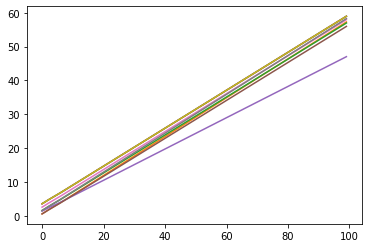

Neuron Label Assignments:
	 Output Neuron[ 0 ]: tensor(0) Proportions: tensor([0.8595, 0.1405]) Rates: tensor([5000.,  817.])
	 Output Neuron[ 1 ]: tensor(1) Proportions: tensor([0.1437, 0.8563]) Rates: tensor([ 839., 5000.])


In [388]:
weight_history = None
num_correct = 0.0

### DEBUG ###

### can be used to assist the network with learning the inputs
supervised = True
log_messages = False
plot_weights = True
epochs = 100

# iterate for epochs
for step in range(epochs):
    for sample in encoded_train_inputs:
        
        # get the label for the current image
        labels[0] = sample["Label"]

        # randomly decide which output neuron should spike if more than one neuron corresponds to the class
        # choice will always be 0 if there is one neuron per output class
        choice = np.random.choice(per_class, size=1, replace=False)

        # clamp on the output layer forces the node corresponding to the label's class to spike
        # this is necessary in order for the network to learn which neurons correspond to which classes
        # clamp: Mapping of layer names to boolean masks if neurons should be clamped to spiking. 
        # The ``Tensor``s have shape ``[n_neurons]`` or ``[time, n_neurons]``.
        clamp = {lif_layer_name: per_class * labels[0] + torch.Tensor(choice).long()} if supervised else {}

        ### Step 1: Run the network with the provided inputs ###
        network.run(inputs=sample["Inputs"], time=time, clamp=clamp)

        ### Step 2: Get the spikes produced at the output layer ###
        spike_record[0] = layer_monitors[lif_layer_name].get("s").view(time, lif_neurons)
        
        ### Step 3: ###

        # Assign labels to the neurons based on highest average spiking activity.
        # Returns a Tuple of class assignments, per-class spike proportions, and per-class firing rates 
        # Return Type: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        assignments, proportions, rates = assign_labels( spike_record, labels, n_classes, rates )

        ### Step 4: Classify data based on the neuron (label) with the highest average spiking activity ###

        # Classify data with the label with highest average spiking activity over all neurons.
        all_activity_pred = all_activity(spike_record, assignments, n_classes)

        ### Step 5: Classify data based on the neuron (label) with the highest average spiking activity
        ###         weighted by class-wise proportion ###
        proportion_pred = proportion_weighting(spike_record, assignments, proportions, n_classes)

        ### Update Accuracy
        num_correct += 1 if (labels.numpy()[0] == all_activity_pred.numpy()[0]) else 0

        ######## Display Information ########
        if log_messages:
            print("Actual Label:",labels.numpy(),"|","Predicted Label:",all_activity_pred.numpy(),"|","Proportionally Predicted Label:",proportion_pred.numpy())
            
            print("Neuron Label Assignments:")
            for idx in range(assignments.numel()):
                print(
                    "\t Output Neuron[",idx,"]:",assignments[idx],
                    "Proportions:",proportions[idx],
                    "Rates:",rates[idx]
                    )
            print("\n")
        #####################################


    ### For Weight Plotting ###
    if plot_weights:
        weights = network.connections[("Input Layer", "LIF Layer")].w[:,0].numpy().reshape((1,input_neurons))
        weight_history = weights.copy() if step == 0 else np.concatenate((weight_history,weights),axis=0)
    print("Neuron 0 Weights:\n",network.connections[("Input Layer", "LIF Layer")].w[:,0])
    print("Neuron 1 Weights:\n",network.connections[("Input Layer", "LIF Layer")].w[:,1])
    print("====================")
    #############################

    if log_messages:
        print("Epoch #",step,"\tAccuracy:", num_correct / ((step + 1) * len(encoded_inputs)) )
        print("===========================\n\n")

### For Weight Plotting ###
# Plot Weight Changes
if plot_weights:
    [plt.plot(weight_history[:,idx]) for idx in range(weight_history.shape[1])]
    plt.show()
    
#############################

### Print Final Class Assignments and Proportions ###
print("Neuron Label Assignments:")
for idx in range(assignments.numel()):
    print(
        "\t Output Neuron[",idx,"]:",assignments[idx],
        "Proportions:",proportions[idx],
        "Rates:",rates[idx]
        )

### 4.6 Evaluate Performance

In [389]:
num_correct = 0

log_messages = True

# disable training mode
network.train(False)

# loop through each test example and record performance
for sample in encoded_test_inputs:

    # get the label for the current image
    labels[0] = sample["Label"]

    ### Step 1: Run the network with the provided inputs ###
    network.run(inputs=sample["Inputs"], time=time)

    ### Step 2: Get the spikes produced at the output layer ###
    spike_record[0] = layer_monitors[lif_layer_name].get("s").view(time, lif_neurons)

    ### Step 3: ###

    # Assign labels to the neurons based on highest average spiking activity.
    # Returns a Tuple of class assignments, per-class spike proportions, and per-class firing rates 
    # Return Type: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
    assignments, proportions, rates = assign_labels( spike_record, labels, n_classes, rates )

    ### Step 4: Classify data based on the neuron (label) with the highest average spiking activity ###

    # Classify data with the label with highest average spiking activity over all neurons.
    all_activity_pred = all_activity(spike_record, assignments, n_classes)

    ### Step 5: Classify data based on the neuron (label) with the highest average spiking activity
    ###         weighted by class-wise proportion ###
    proportion_pred = proportion_weighting(spike_record, assignments, proportions, n_classes)

    ### Update Accuracy
    num_correct += 1 if (labels.numpy()[0] == all_activity_pred.numpy()[0]) else 0

    ######## Display Information ########
    if log_messages:
        print("Actual Label:",labels.numpy(),"|","Predicted Label:",all_activity_pred.numpy(),"|","Proportionally Predicted Label:",proportion_pred.numpy())
        
        print("Neuron Label Assignments:")
        for idx in range(assignments.numel()):
            print(
                "\t Output Neuron[",idx,"]:",assignments[idx],
                "Proportions:",proportions[idx],
                "Rates:",rates[idx]
                )
        print("\n")
    #####################################
print("Accuracy:", num_correct / len(encoded_test_inputs) )

Actual Label: [1] | Predicted Label: [0] | Proportionally Predicted Label: [0]
Neuron Label Assignments:
	 Output Neuron[ 0 ]: tensor(0) Proportions: tensor([0.8593, 0.1407]) Rates: tensor([5000.,  819.])
	 Output Neuron[ 1 ]: tensor(1) Proportions: tensor([0.1436, 0.8564]) Rates: tensor([ 839., 5002.])


Actual Label: [1] | Predicted Label: [1] | Proportionally Predicted Label: [1]
Neuron Label Assignments:
	 Output Neuron[ 0 ]: tensor(0) Proportions: tensor([0.8591, 0.1409]) Rates: tensor([5000.,  820.])
	 Output Neuron[ 1 ]: tensor(1) Proportions: tensor([0.1436, 0.8564]) Rates: tensor([ 839., 5004.])


Actual Label: [1] | Predicted Label: [0] | Proportionally Predicted Label: [0]
Neuron Label Assignments:
	 Output Neuron[ 0 ]: tensor(0) Proportions: tensor([0.8588, 0.1412]) Rates: tensor([5000.,  822.])
	 Output Neuron[ 1 ]: tensor(1) Proportions: tensor([0.1436, 0.8564]) Rates: tensor([ 839., 5005.])


Actual Label: [0] | Predicted Label: [0] | Proportionally Predicted Label: [0]


## 5. Learning Rules

### 5a. PostPre

Simple STDP rule involving both pre- and post-synaptic spiking activity. By default, pre-synaptic update is negative and the post-synaptic update is positive.

| Parameters   | Type                                    | Description                                                                               | Default Value |
|--------------|-----------------------------------------|-------------------------------------------------------------------------------------------|---------------|
| connection   | AbstractConnection                      | An `AbstractConnection` object whose weights the `PostPre` learning rule will modify. |               |
| nu           | Optional\[Union\[float, Sequence\[float]]] | Single or pair of learning rates for pre- and post-synaptic events.                       | None          |
| reduction    | Optional\[callable]                      | Method for reducing parameter updates along the batch                                     | None          |
| weight_decay | float                                   | Constant multiple to decay weights by on each iteration.                                  | 0.0           |

## 6. Custom Learning Rules

Custom learning rules can be implemented by subclassing `bindsnet.learning.LearningRule` and providing implementations for the types of `AbstractConnection` objects intended to be used. 

For example, the `Connection` and `LocalConnection` objects rely on the implementation of a private method, `_connection_update`, whereas the `Conv2dConnection` object uses the `_conv2d_connection_update` version.